# From EDA to the top
https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367

## Introduction
이번 대회에서는 뉴욕 택시 여행의 총 주행 시간을 예측하는 모델을 구축해야 합니다. 꽤 많은 EDA 커널과 그 중 일부는 훌륭합니다. 여기서는 피처 추출에 더 초점을 맞추려고 합니다. 이 커널에서는 몇 가지 일반적인 캐글 관련 팁과 몇 가지 모델링 개선 아이디어도 찾을 수 있습니다.

주요 목표는 주어진 커널 제한으로 XGB에 대해 가능한 최상의 피처 세트를 만드는 것입니다.

현재 최고의 제출은 여전히 이 스크립트를 기반으로 합니다. 이러한 피처를 갖춘 최고의 단일 모델은 LB 0.371에 도달했습니다. 여러 모델의 선형 조합은 LB 0.368을 제공했습니다. 스태킹에는 0.367의 한계 개선이 추가됐습니다.

이 노트북에서는 아래와 같은 내용을 다룹니다.
- 데이터셋 탐색
- 59개의 유용한 피처 추출
- 80-20의 훈련 / 검증 셋 분할
- XGBregressor 훈련
- 피처 중요도 분석
- 테스트 셋 점수와 제출
- XGB 파라미터 체크를 통해 향상성 탐색

In [119]:
%matplotlib inline
import numpy as np
import pandas as pd
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings
warnings.filterwarnings('ignore')

## Data Understanding

In [120]:
np.random.seed(1987)
N = 100000 # 플롯의 샘플 행 수 
t0 = dt.datetime.now()
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')
sample_submission = pd.read_csv('./input/sample_submission.csv')

데이터 파일을 확인해 보겠습니다. 데이터 설명은 다음과 같습니다.
- id: 각 트립에 대한 고유 식별자
- vendor_id: 트립 레코드와 연결된 제공자를 나타내는 코드
- pickup_datetime: 미터기가 작동된 날짜 및 시간
- dropoff_datetime: 미터기가 해제된 날짜 및 시간
- passenger_count: 차량 내 승객 수(운전자 포함)
- pickup_longitude: 미터기가 체결된 경도
- pickup_latitude: 미터기가 체결된 위도
- dropoff_longitude: 미터기가 해제된 경도
- dropoff_latitude: 미터기가 해제된 위도
- store_and_fwd_flag: 차량이 서버에 연결되지 않아 벤더에 전송하기 전에 트립 레코드가 차량 메모리에 저장되었는지 여부를 나타냄(Y=저장, N=저장안함)
- trip_duration: 여행 기간(초)

dropoff_datetime과 trip_duration은 훈련 셋에서만 이용 가능합니다.

In [121]:
print("{}개의 훈련 행과 {}개의 테스트 행 가짐".format(train.shape[0], test.shape[0]))
print("{}개의 훈련 열과 {}개의 테스트 열 가짐".format(train.shape[1], test.shape[1]))
train.head(2)

1458644개의 훈련 행과 625134개의 테스트 행 가짐
11개의 훈련 열과 9개의 테스트 열 가짐


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


In [122]:
print('Id is unique') if train.id.nunique() == train.shape[0] else print('oops')
print('Train and test set 교집합 없음') if len(np.intersect1d(train.id.values, test.id.values)) == 0 else print('oops')
print('결측치 없음') if train.count().min() == train.shape[0] and test.count().min() == test.shape[0] else print('oops')
print('store_and_fwd_flag는 오직 두 값만 가짐 {}'.format(str(set(train.store_and_fwd_flag.unique()) | set(test.store_and_fwd_flag.unique()))))

Id is unique
Train and test set 교집합 없음
결측치 없음
store_and_fwd_flag는 오직 두 값만 가짐 {'N', 'Y'}


In [123]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)
train['store_and_fwd_flag'] = 1 * (train.store_and_fwd_flag.values == 'Y')
test['store_and_fwd_flag'] = 1 * (test.store_and_fwd_flag.values == 'Y')
train['check_trip_duration'] = (train['dropoff_datetime'] - train['pickup_datetime']).map(lambda x: x.total_seconds())
duration_difference = train[np.abs(train['check_trip_duration'].values - train['trip_duration'].values) > 1]
print('Trip_duration 과 datetimes 완료') if len(duration_difference[['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration']]) == 0 else print('oops')

Trip_duration 과 datetimes 완료


In [124]:
train['trip_duration'].max() // 3600

979

최대 trip_duration 시간은 약 1000시간 까지입니다. 다행히 평가 메트릭은 RMSLE이며 RMSE는 아닙니다. 이상치는 문제를 덜 일으킬 것입니다. 우리는 우리의 타겟 레이블을 변환하고 훈련중에 RMSE를 사용할 수 있습니다.

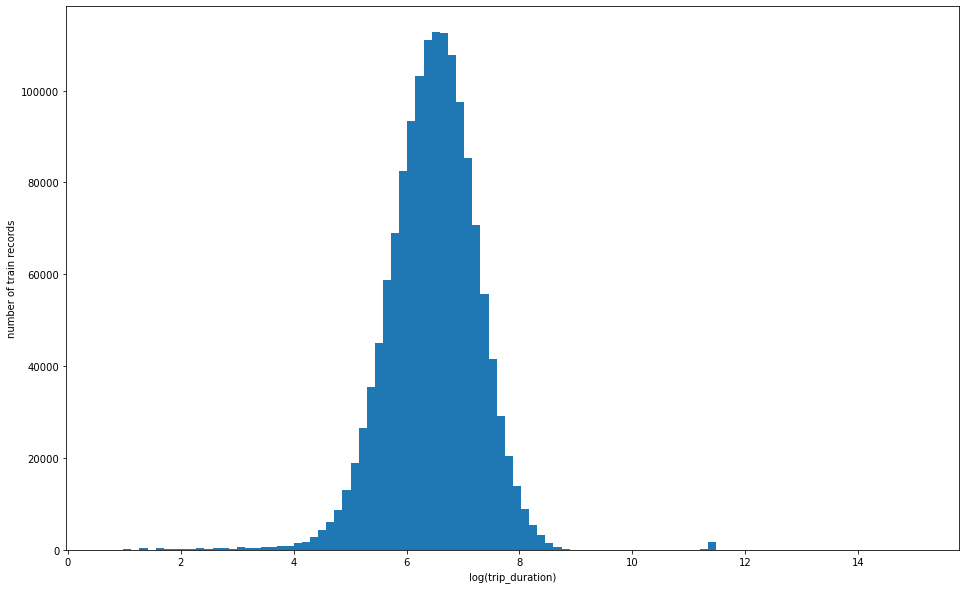

In [125]:
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

## Validation Strategy
먼저 train test split을 확인해보겠습니다. 검증 전략을 결정하고 피처 엔지니어링에 대한 아이디어를 제공합니다.

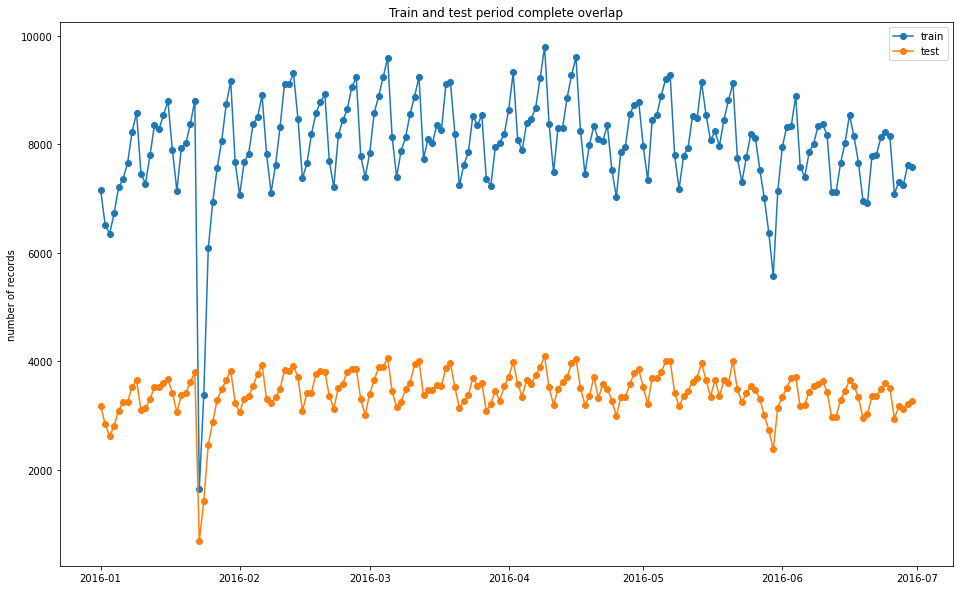

In [126]:
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Train and test period complete overlap')
plt.legend(loc=0)
plt.ylabel('number of records')
plt.show()

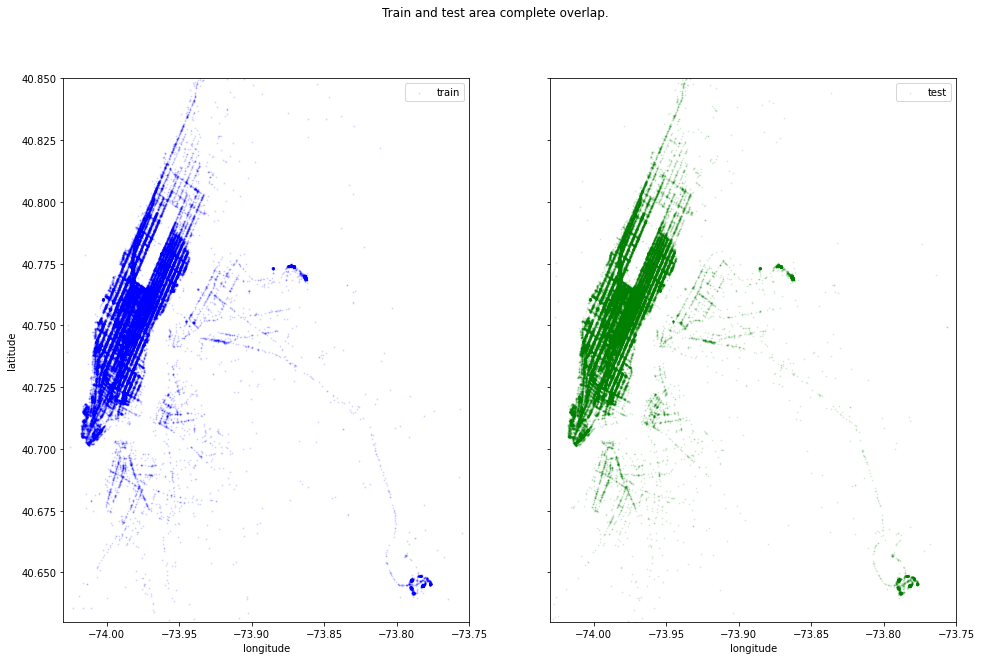

In [127]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(test['pickup_longitude'].values[:N], test['pickup_latitude'].values[:N],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

이 경우 훈련과 테스트 분할은 랜덤으로 보입니다. 이를 통해 전체 데이터 세트에 적용할 비지도 학습 및 피처 추출을 사용할 수 있습니다.

## Feature Extraction

### PCA
PCA를 사용하여 경도와 위도 좌표를 변환합니다. 이 경우 2D -> 2D로 변환하기 때문에 차원 축소에 관한 것이 아닙니다. 회전을 통해 의사 결정 트리 분할에 도움을 줄 수 있습니다.

In [128]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values,))

pca = PCA().fit(coords)
train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

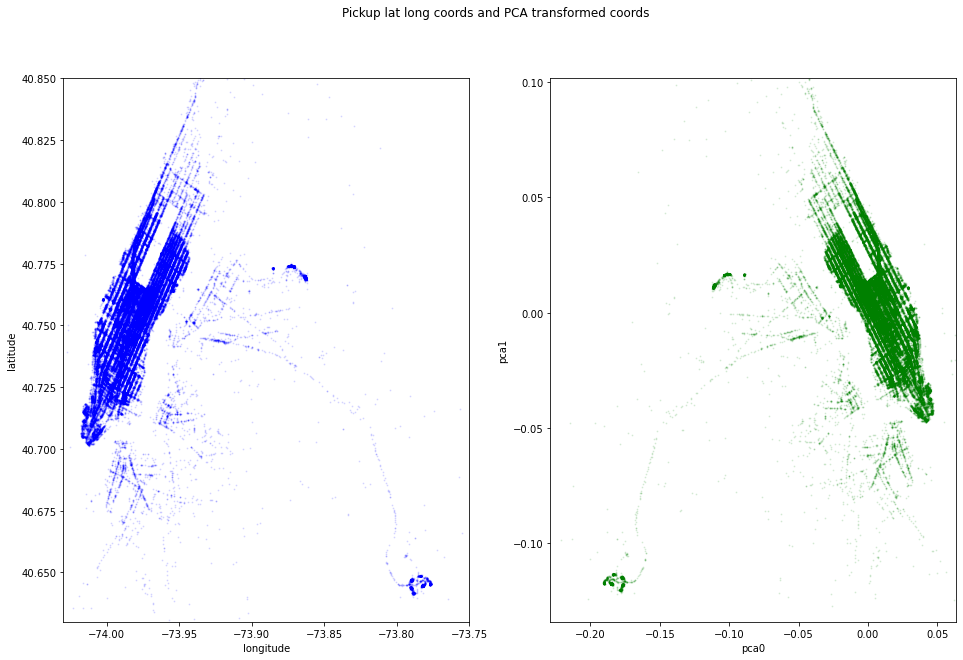

In [129]:
fig, ax = plt.subplots(ncols=2)
ax[0].scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N],
              color='blue', s=1, alpha=0.1)
ax[1].scatter(train['pickup_pca0'].values[:N], train['pickup_pca1'].values[:N],
              color='green', s=1, alpha=0.1)
fig.suptitle('Pickup lat long coords and PCA transformed coords')
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('pca0')
ax[1].set_ylabel('pca1')
ax[0].set_xlim(city_long_border)
ax[0].set_ylim(city_lat_border)
pca_borders = pca.transform([[x, y] for x in city_lat_border for y in city_long_border])
ax[1].set_xlim(pca_borders[:, 0].min(), pca_borders[:, 0].max())
ax[1].set_ylim(pca_borders[:, 1].min(), pca_borders[:, 1].max())
plt.show()

### Distance
픽업 지점과 드롭오프 지점 사이의 거리(km)를 계산해보겠습니다. 현재 Haversine이 사용되고 있는 지오피에는 원하는 경우 다른 휴리스틱(vincenty() 또는 great_circle())이 있습니다. 택시는 운행되지 않고 뉴욕이기 때문에 맨해튼(L1) 거리도 확인할 수 있습니다. 

pd.DataFrame.apply()가 너무 느려서 harvesine 기능이 다시 쓰여 어레이를 처리할 수 없습니다. 또한 경로의 중간을 피처로 추가합니다.

In [130]:
def harversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371 # km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = harversine_array(lat1, lng1, lat1, lng2)
    b = harversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371 
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

train.loc[:, 'distance_haversine'] = harversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'pca_manhattan'] = np.abs(train['dropoff_pca1'] - train['pickup_pca1']) + np.abs(train['dropoff_pca0'] - train['pickup_pca0'])

test.loc[:, 'distance_haversine'] = harversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'direction'] = bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'pca_manhattan'] = np.abs(test['dropoff_pca1'] - test['pickup_pca1']) + np.abs(test['dropoff_pca0'] - test['pickup_pca0'])

train.loc[:, 'center_latitude'] = (train['pickup_latitude'].values + train['dropoff_latitude'].values) / 2
train.loc[:, 'center_longitude'] = (train['pickup_longitude'].values + train['dropoff_longitude'].values) / 2
test.loc[:, 'center_latitude'] = (test['pickup_latitude'].values + test['dropoff_latitude'].values) / 2
test.loc[:, 'center_longitude'] = (test['pickup_longitude'].values + test['dropoff_longitude'].values) / 2

### Datetime features

In [131]:
train.loc[:, 'pickup_weekday'] = train['pickup_datetime'].dt.weekday
train.loc[:, 'pickup_hour_weekofyear'] = train['pickup_datetime'].dt.weekofyear
train.loc[:, 'pickup_hour'] = train['pickup_datetime'].dt.hour
train.loc[:, 'pickup_minute'] = train['pickup_datetime'].dt.minute
train.loc[:, 'pickup_dt'] = (train['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
train.loc[:, 'pickup_week_hour'] = train['pickup_weekday'] * 24 + train['pickup_hour']

test.loc[:, 'pickup_weekday'] = test['pickup_datetime'].dt.weekday
test.loc[:, 'pickup_hour_weekofyear'] = test['pickup_datetime'].dt.weekofyear
test.loc[:, 'pickup_hour'] = test['pickup_datetime'].dt.hour
test.loc[:, 'pickup_minute'] = test['pickup_datetime'].dt.minute
test.loc[:, 'pickup_dt'] = (test['pickup_datetime'] - test['pickup_datetime'].min()).dt.total_seconds()
test.loc[:, 'pickup_week_hour'] = test['pickup_weekday'] * 24 + train['pickup_hour']

### Speed

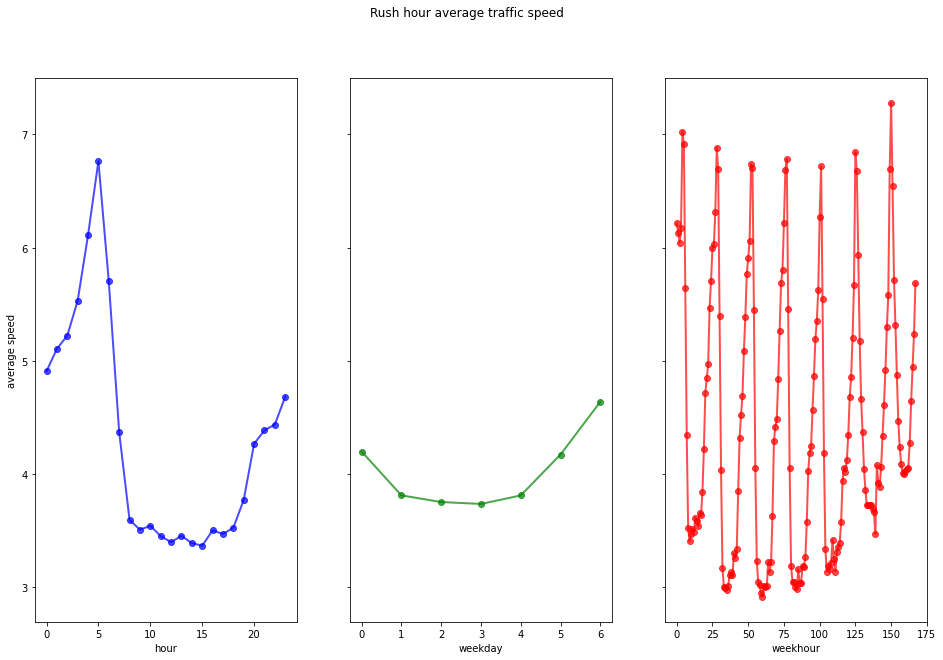

In [132]:
train.loc[:, 'avg_speed_h'] = 1000 * train['distance_haversine'] / train['trip_duration']
train.loc[:, 'avg_speed_m'] = 1000 * train['distance_dummy_manhattan'] / train['trip_duration']
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(train.groupby('pickup_hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('pickup_weekday').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[2].plot(train.groupby('pickup_week_hour').mean()['avg_speed_h'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('hour')
ax[1].set_xlabel('weekday')
ax[2].set_xlabel('weekhour')
ax[0].set_ylabel('average speed')
fig.suptitle('Rush hour average traffic speed')
plt.show()

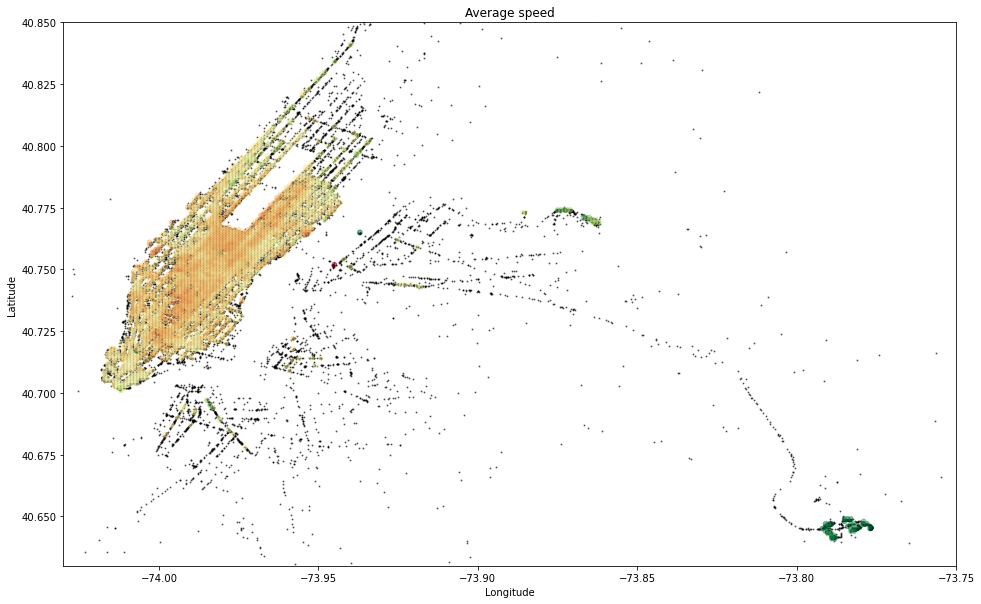

In [133]:
train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 3)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 3)
# Average speed for regions
gby_cols = ['pickup_lat_bin', 'pickup_long_bin']
coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
coord_stats = coord_stats[coord_stats['id'] > 100]
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:N], train.pickup_latitude.values[:N],
           color='black', s=1, alpha=0.5)
ax.scatter(coord_stats.pickup_long_bin.values, coord_stats.pickup_lat_bin.values,
           c=coord_stats.avg_speed_h.values,
           cmap='RdYlGn', s=20, alpha=0.5, vmin=1, vmax=8)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Average speed')
plt.show()

train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 2)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 2)
train.loc[:, 'center_lat_bin'] = np.round(train['center_latitude'], 2)
train.loc[:, 'center_long_bin'] = np.round(train['center_longitude'], 2)
train.loc[:, 'pickup_dt_bin'] = (train['pickup_dt'] // (3 * 3600))
test.loc[:, 'pickup_lat_bin'] = np.round(test['pickup_latitude'], 2)
test.loc[:, 'pickup_long_bin'] = np.round(test['pickup_longitude'], 2)
test.loc[:, 'center_lat_bin'] = np.round(test['center_latitude'], 2)
test.loc[:, 'center_long_bin'] = np.round(test['center_longitude'], 2)
test.loc[:, 'pickup_dt_bin'] = (test['pickup_dt'] // (3 * 3600))

### Clustering

In [134]:
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

In [135]:
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])
t1 = dt.datetime.now()
print('클러스터링 시간: %i 초' % (t1 - t0).seconds)

클러스터링 시간: 84 초


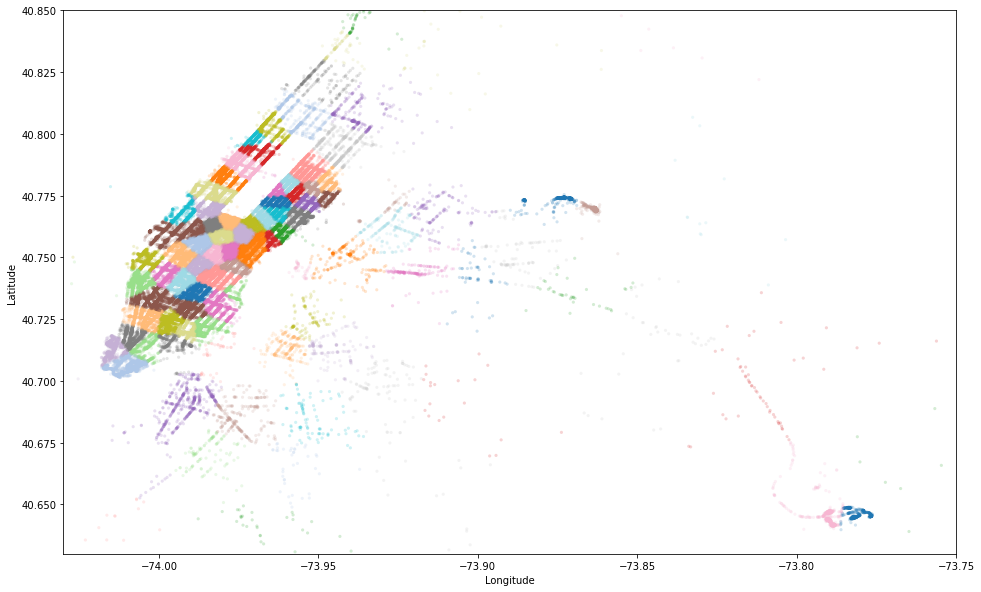

In [136]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:N], train.pickup_latitude.values[:N], s=10, lw=0, c=train.pickup_cluster[:N].values, cmap='tab20', alpha=.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

### Temporal and geospatial aggregation
몇 가지 평균 트래픽 속도 피처를 추가합니다. 훈련/테스트 분할이 시간 기반이라면 시간적 특징을 많이 사용할 수 없다는 점에 유의하십시오. 이 경쟁에서 우리는 미래를 예측할 필요가 없습니다.

In [137]:
for gby_col in ['pickup_hour', 'pickup_date', 'pickup_dt_bin', 
                'pickup_week_hour', 'pickup_cluster', 'dropoff_cluster']:
    gby = train.groupby(gby_col).mean()[['avg_speed_h', 'avg_speed_m', 'log_trip_duration']]
    gby.columns = ['%s_gby_%s' % (col, gby_col) for col in gby.columns]
    train = pd.merge(train, gby, how='left', left_on=gby_col, right_index=True)
    test = pd.merge(test, gby, how='left', left_on=gby_col, right_index=True)
    
for gby_cols in [['center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'pickup_cluster'],
                 ['pickup_hour', 'dropoff_cluster'],
                 ['pickup_cluster', 'dropoff_cluster']]:
    coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
    coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
    coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
    coord_stats = coord_stats[coord_stats['id'] > 100]
    coord_stats.columns = gby_cols + ['avg_speed_h_%s' % '_'.join(gby_cols), 'cnt_%s' % '_'.join(gby_cols)]
    train = pd.merge(train, coord_stats, how='left', on=gby_cols)
    test = pd.merge(test, coord_stats, how='left', on=gby_cols)

In [138]:
group_freq = '60min'
df_all = pd.concat((train, test))[['id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]
train.loc[:, 'pickup_datetime_group'] = train['pickup_datetime'].dt.round(group_freq)
test.loc[:, 'pickup_datetime_group'] = test['pickup_datetime'].dt.round(group_freq)

# 60분 이상 걸리는 횟수 카운트
df_counts = df_all.set_index('pickup_datetime')[['id']].sort_index()
df_counts['count_60min'] = df_counts.isnull().rolling(group_freq).count()['id']
train = train.merge(df_counts, on='id', how='left')
test = test.merge(df_counts, on='id', how='left')

# 시간 경과에 따른 각 클러스터로의 이동 횟수 계산
dropoff_counts = df_all\
.groupby([pd.Grouper(key='pickup_datetime',
                     freq=group_freq), 'dropoff_cluster'])\
.agg({'id': 'count'})\
.reset_index()\
.set_index('pickup_datetime')\
.groupby('dropoff_cluster')\
.rolling('240min')\
.mean()\
.drop('dropoff_cluster', axis=1)\
.reset_index().set_index('pickup_datetime')\
.shift(freq='-120min')\
.reset_index()\
.rename(columns={'pickup_datetime': 'pickup_datetime_group',
                 'id': 'dropoff_cluster_count'})

train['dropoff_cluster_count'] = train[['pickup_datetime_group', 'dropoff_cluster']].merge(dropoff_counts, on=['pickup_datetime_group', 'dropoff_cluster'], how='left')['dropoff_cluster_count'].fillna(0)
test['dropoff_cluster_count'] = test[['pickup_datetime_group', 'dropoff_cluster']].merge(dropoff_counts, on=['pickup_datetime_group', 'dropoff_cluster'], how='left')['dropoff_cluster_count'].fillna(0)


In [139]:
# 시간이 지남에 따라 각 클러스터에서 이동하는 횟수 계산
df_all = pd.concat((train, test))[['id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]
pickup_counts = df_all \
.groupby([pd.Grouper(key='pickup_datetime',
                     freq=group_freq), 'pickup_cluster']) \
.agg({'id': 'count'}) \
.reset_index().set_index('pickup_datetime') \
.groupby('pickup_cluster').rolling('240min').mean() \
.drop('pickup_cluster', axis=1) \
.reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
.rename(columns={'pickup_datetime': 'pickup_datetime_group', 'id': 'pickup_cluster_count'})

train['pickup_cluster_count'] = train[['pickup_datetime_group', 'pickup_cluster']].merge(pickup_counts, on=['pickup_datetime_group', 'pickup_cluster'], how='left')['pickup_cluster_count'].fillna(0)
test['pickup_cluster_count'] = test[['pickup_datetime_group', 'pickup_cluster']].merge(pickup_counts, on=['pickup_datetime_group', 'pickup_cluster'], how='left')['pickup_cluster_count'].fillna(0)

In [140]:
print(train.shape, test.shape)

(1458644, 71) (625134, 65)


## OSRM Features
이전 버전에서는 대략적인 거리 추정치만 있었습니다. 이제 우리는 픽업과 하차 사이의 더 빠른 경로 거리 추정치를 사용합니다.

In [141]:
fr1 = pd.read_csv('./input/fastest_routes_train_part_1.csv', usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
fr2 = pd.read_csv('./input/fastest_routes_train_part_2.csv', usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
test_street_info = pd.read_csv('./input/fastest_routes_test.csv', usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
train_street_info = pd.concat((fr1, fr2))
train = train.merge(train_street_info, how='left', on='id')
test = test.merge(test_street_info, how='left', on='id')
train_street_info.head()

,id,total_distance,total_travel_time,number_of_steps
0,id2875421,2009.1,164.9,5
1,id2377394,2513.2,332.0,6
2,id3504673,1779.4,235.8,4
3,id2181028,1614.9,140.1,5
4,id0801584,1393.5,189.4,5


In [142]:
feature_names = list(train.columns)
print(np.setdiff1d(train.columns, test.columns))
do_not_use_for_training = ['id', 'log_trip_duration', 'pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration', 'pickup_date', 'avg_speed_h', 'avg_speed_m', 'pickup_lat_bin', 'pickup_long_bin', 'center_lat_bin', 'center_long_bin', 'pickup_df_bin', 'pickup_datetime_group']
feature_names = [f for f in train.columns if f not in do_not_use_for_training]

print('%i 개의 피쳐 보유' % len(feature_names))
train[feature_names].count()
y = np.log(train['trip_duration'].values + 1)

t1 = dt.datetime.now()
print('피처 추출 시간: %i 초' % (t1 - t0).seconds)

['avg_speed_h' 'avg_speed_m' 'check_trip_duration' 'dropoff_datetime'
 'log_trip_duration' 'trip_duration']
60 개의 피쳐 보유
피처 추출 시간: 225 초


### Feature check before modeling
모델링하기 전에 훈련 및 테스트 피처 분포를 확인하는 것이 좋습니다. 보통 캐글에서 훈련과 테스트 세트는 iid입니다. 훈련과 테스트 셋간에 피처 추출 파이프라인에 버그가 있을 수 있는 것과 큰 차이가 있는 경우입니다.

In [146]:
feature_stats = pd.DataFrame({'feature': feature_names})
feature_stats.loc[:, 'train_mean'] = np.nanmean(train[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'test_mean'] = np.nanmean(test[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'train_std'] = np.nanstd(train[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'test_std'] = np.nanstd(test[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'train_nan'] = np.mean(np.isnan(train[feature_names].values), axis=0).round(3)
feature_stats.loc[:, 'test_nan'] = np.mean(np.isnan(test[feature_names].values), axis=0).round(3)
feature_stats.loc[:, 'train_test_mean_diff'] = np.abs(feature_stats['train_mean'] - feature_stats['test_mean']) / np.abs(feature_stats['train_std'] + feature_stats['test_std'])  * 2
feature_stats.loc[:, 'train_test_nan_diff'] = np.abs(feature_stats['train_nan'] - feature_stats['test_nan'])
feature_stats = feature_stats.sort_values(by='train_test_mean_diff')
feature_stats[['feature', 'train_test_mean_diff']].tail()

,feature,train_test_mean_diff
10,dropoff_pca1,0.002833
18,pickup_hour_weekofyear,0.002872
37,log_trip_duration_gby_pickup_week_hour,0.062706
35,avg_speed_h_gby_pickup_week_hour,0.081220
36,avg_speed_m_gby_pickup_week_hour,0.081730


In [147]:
feature_stats = feature_stats.sort_values(by='train_test_nan_diff')
feature_stats[['feature', 'train_nan', 'test_nan', 'train_test_nan_diff']].tail()

,feature,train_nan,test_nan,train_test_nan_diff
22,pickup_week_hour,0.000,0.000,0.000
32,avg_speed_h_gby_pickup_dt_bin,0.000,0.000,0.000
36,avg_speed_m_gby_pickup_week_hour,0.000,0.000,0.000
52,avg_speed_h_pickup_cluster_dropoff_cluster,0.105,0.107,0.002
53,cnt_pickup_cluster_dropoff_cluster,0.105,0.107,0.002


최상위 평균 차이도 표준 편차의 1% 미만입니다. 누락된 값이 몇 개 있지만 누락된 비율은 동일합니다. 다행히 xgboost는 결측값을 처리할 수 있습니다.

## Modeling

In [149]:
Xtr, Xv, ytr, yv = train_test_split(train[feature_names].values, y, test_size=0.2, random_state=1987)
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test[feature_names].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10, 'subsample': 0.8, 'lambda': 1., 'nthread': 4, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}

In [150]:
# 더 많은 에폭으로 훈련 필요
model = xgb.train(xgb_pars, dtrain, 60, watchlist, early_stopping_rounds=50, maximize=False, verbose_eval=10)

[16:10:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:10:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:4.22537	valid-rmse:4.22646
[10]	train-rmse:0.39834	valid-rmse:0.41308
[20]	train-rmse:0.36864	valid-rmse:0.38946
[30]	train-rmse:0.36166	valid-rmse:0.38744
[40]	train-rmse:0.35585	valid-rmse:0.38670
[50]	train-rmse:0.35118	valid-rmse:0.38542
[59]	train-rmse:0.34740	valid-rmse:0.38504


In [151]:
print('Modeling RMSLE %.5f' % model.best_score)
t1 = dt.datetime.now()
print('Training time: %i seconds' % (t1 - t0).seconds)

Modeling RMSLE 0.38504
Training time: 1409 seconds


### Feature importance analysis
XGB 모델에는 종종 사용되는 피처 중요도 점수가 있습니다. 꼭 필요한 것은 피처가 매우 중요하다는 것을 의미하지 않으며, 점수가 높으면 피처가 더 많은 트리 분할에 사용되었다는 것을 의미합니다. 상관 관계가 강하거나 카디널리티 편향이 높은 특성이 결과에 영향을 미칩니다.

간단한 역방향 피처 제거 라운딩을 시도했습니다. 각 피처에 대해 해당 피처 없이 새 모델을 교육했습니다. 제거해서는 안 되는 필수 피처가 무엇인지 이해하는데 도움이 됩니다. 56개 모델을 교육하는 데 몇 시간이 걸리므로 오프라인 검증 결과를 사용합니다.

OSRM 피처는 나중에 추가되어 다음 섹션에 포함되지 않음을 유의하십시오.

In [153]:
rmse_wo_feature = [0.39224, 0.38816, 0.38726, 0.38780, 0.38773, 0.38792, 0.38753, 0.38745, 0.38710, 0.38767, 0.38738, 0.38750, 0.38678, 0.39359, 0.38672, 0.38794, 0.38694, 0.38750, 0.38742, 0.38673, 0.38754, 0.38705, 0.38736, 0.38741, 0.38764, 0.38730, 0.38676, 0.38696, 0.38750, 0.38705, 0.38746, 0.38727, 0.38750, 0.38771, 0.38747, 0.38907, 0.38719, 0.38756, 0.38701, 0.38734, 0.38782, 0.38673, 0.38797, 0.38720, 0.38709, 0.38704, 0.38809, 0.38768, 0.38798, 0.38849, 0.38690, 0.38753, 0.38721, 0.38807, 0.38830, 0.38750, np.nan, np.nan, np.nan, np.nan]
feature_importance_dict = model.get_fscore()
fs = ['f%i' % i for i in range(len(feature_names))]
f1 = pd.DataFrame({'f': list(feature_importance_dict.keys()),
                   'importance': list(feature_importance_dict.values())})
f2 = pd.DataFrame({'f': fs, 'feature_name': feature_names, 'rmse_wo_feature': rmse_wo_feature})
feature_importance = pd.merge(f1, f2, how='right', on='f')
feature_importance = feature_importance.fillna(0)

feature_importance[['feature_name', 'importance', 'rmse_wo_feature']].sort_values(by='importance', ascending=False)

,feature_name,importance,rmse_wo_feature
13,direction,1059,0.39359
12,distance_dummy_manhattan,953,0.38678
54,count_60min,709,0.38830
8,pickup_pca1,699,0.38710
58,total_travel_time,683,0.00000
11,distance_haversine,667,0.38750
10,dropoff_pca1,658,0.38738
57,total_distance,622,0.00000
52,avg_speed_h_pickup_cluster_dropoff_cluster,611,0.38721
2,pickup_longitude,595,0.38726


다음 그림은 피처 제거 결과와 xgb 중요성을 보여줍니다. 몇 가지 관측치가 있습니다.

- 우리는 피처 중요도가 높은 위치 관련 피처를 꽤 많이 가지고 있었지만, 하나를 제거해도 오류가 커지지 않습니다.
- vendor_id는 피처 중요도에 따라 두 번째로 적게 사용되는 피처지만 이를 제거하면 그 값이 유의하게 증가합니다. 이 값은 이진 값이며, 이를 사용하는 소수의 의사 결정 트리도 정보를 캡쳐합니다.
- 방향은 양쪽 측면에서 중요합니다. 상관 관계가 있는 피처가 많지 않으므로 제거하면 모델이 손상될 수 있습니다.
실제 프로젝트에서는 변수가 적은 모델을 선호하지만, 캐글에서는 사소한 개선점만 주더라도 더 많은 변수를 가질 수 없습니다.

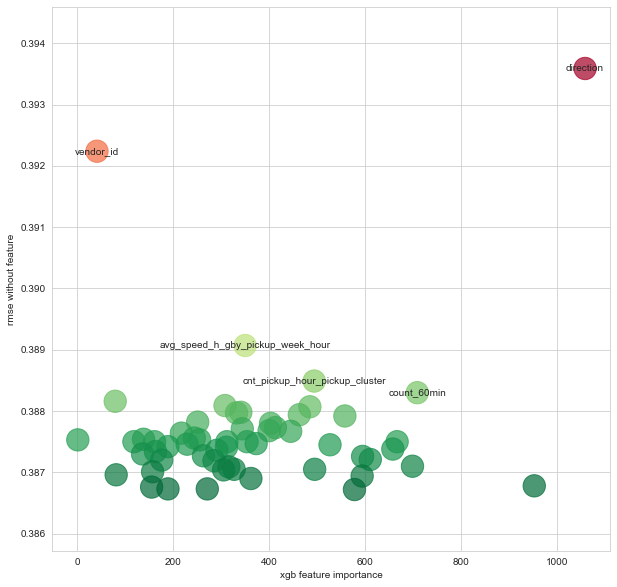

In [154]:
feature_importance = feature_importance.sort_values(by='rmse_wo_feature', ascending=False)
feature_importance = feature_importance[feature_importance['rmse_wo_feature'] > 0]
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(feature_importance['importance'].values, feature_importance['rmse_wo_feature'].values, c=feature_importance['rmse_wo_feature'].values, s=500, cmap='RdYlGn_r', alpha=0.7)
    for _, row in feature_importance.head(5).iterrows():
        ax.text(row['importance'], row['rmse_wo_feature'], row['feature_name'], verticalalignment='center', horizontalalignment='center')
    ax.set_xlabel('xgb feature importance')
    ax.set_ylabel('rmse without feature')
    ax.set_ylim(np.min(feature_importance['rmse_wo_feature']) - 0.001,
                np.max(feature_importance['rmse_wo_feature']) + 0.001)
    plt.show()

Text(0, 0.5, 'ground truth')

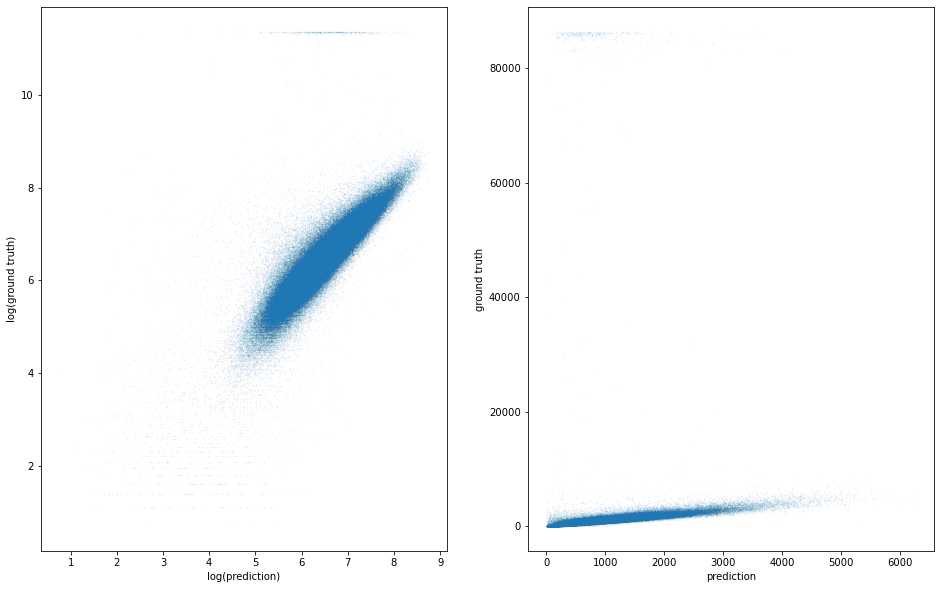

In [155]:
ypred = model.predict(dvalid)
fig, ax = plt.subplots(ncols=2)
ax[0].scatter(ypred, yv, s=0.1, alpha=0.1)
ax[0].set_xlabel('log(prediction)')
ax[0].set_ylabel('log(ground truth)')
ax[1].scatter(np.exp(ypred), np.exp(yv), s=0.1, alpha=0.1)
ax[1].set_xlabel('prediction')
ax[1].set_ylabel('ground truth')


## Submission
로그 기간을 다시 변환하고 제출 파일을 저장해야 합니다.

대부분의 경우 매일 5개의 제출 슬롯은 로컬에서 실험을 검증할 수 있고 검증해야 하므로 충분합니다. 팀워크를 하고 있거나 대회가 막바지에 이른 경우 제출하기 전에 버그를 피하고 싶습니다. 여기서는 유효한 예측 분포와 검정 예측 분포를 확인합니다. 아이디 분할로 인해 그들은 똑같이 보여야 합니다. 이전 제출물과의 상관 관계를 확인하면 더 많은 신뢰를 얻을 수 있습니다.

Test shape ok
Valid prediction mean: 6.467
Test prediction mean: 6.457


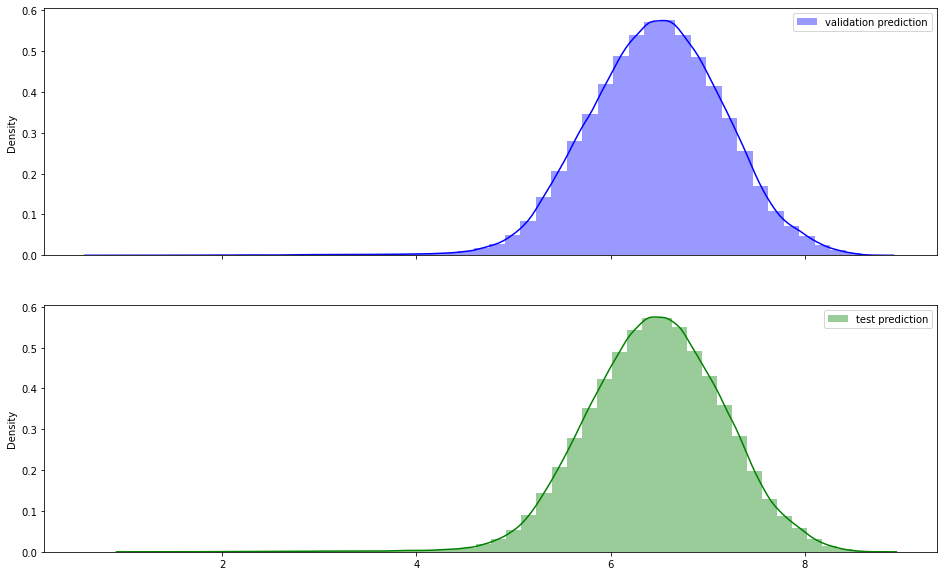

Total time: 2695 seconds


In [156]:
ytest = model.predict(dtest)
print('Test shape ok') if test.shape[0] == ytest.shape[0] else print('oops')
test['trip_duration'] = np.exp(ytest) - 1
test[['id', 'trip_duration']].to_csv('beluga_xgb_submission.csv.gz', index=False, compression='gzip')

print('Valid prediction mean: %.3f' % ypred.mean())
print('Test prediction mean: %.3f' % ytest.mean())

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
sns.distplot(ypred, ax=ax[0], color='blue', label='validation prediction')
sns.distplot(ytest, ax=ax[1], color='green', label='test prediction')
ax[0].legend(loc=0)
ax[1].legend(loc=0)
plt.show()

t1 = dt.datetime.now()
print('Total time: %i seconds'% (t1 - t0).seconds)

분포가 동일한 것 같습니다. 제출할 준비가 되었습니다.

## XGB Parameter Search Result
파라미터 튜닝의 경우 랜덤 선택을 선호합니다. 일반적으로 다음 매개 변수에 대해 다른 값을 사용합니다.

- min_child_weight
- eta
- colsample_bytree
- max_depth
- subsample
- lambda

sklearn CV 옵션(Randomized SearchCV 또는 GridSearchCV)을 좋아하지만, 일반적인 경쟁에서는 단일 모델에 대한 교육이 몇 시간이 걸릴 수 있으며 중간 결과(성능 메트릭, of 예측 등)를 저장하기 때문에 사용자 지정 검색을 사용합니다. 결과에 따라 그리드 검색 지점을 수동으로 설정하려고 합니다. 간단한 임의 파라미터 검색은 다음과 같습니다.

In [158]:
FOREVER_COMPUTING_FLAG = False
xgb_pars = []
for MCW in [10, 20, 50, 75, 100]:
    for ETA in [0.05, 0.1, 0.15]:
        for CS in [0.3, 0.4, 0.5]:
            for MD in [6, 8, 10, 12, 15]:
                for SS in [0.5, 0.6, 0.7, 0.8, 0.9]:
                    for LAMBDA in [0.5, 1., 1.5, 2., 3.]:
                        xgb_pars.append({'min_child_weight': MCW,
                                         'eta': ETA,
                                         'colsample_bytree': CS,
                                         'max_depth': MD,
                                         'subsample': SS,
                                         'lambda': LAMBDA,
                                         'nthread': -1,
                                         'booster': 'gbtree',
                                         'eval_metric': 'rmse',
                                         'silent': 1,
                                         'objective': 'reg:linear'})
                        
while FOREVER_COMPUTING_FLAG:
    xgb_parsb = np.random.choice(xgb_pars, 1)[0]
    print(xgb_par)
    model = xgb.train(xgb_par, dtrain, 2000, watchlist, early_stopping_rounds=50, maximize=False, verbose_eval=100)
    print('Modeling RMSLE %.5f' % model.best_score)

이러한 실험은 커널 제한보다 훨씬 더 많이 수행되므로 결과의 하위 집합이 여기에 복사됩니다.

In [159]:
paropt = pd.DataFrame({'lambda':[1.5,1.0,1.0,1.5,1.5,1.0,1.5,1.0,1.5,2.0,0.5,1.0,0.5,1.5,1.5,0.5,1.0,1.5,0.5,2.0,1.0,2.0,2.0,1.5,1.5,2.0,1.5,2.0,1.5,0.5,1.0,1.0,2.0,1.5,1.0,1.0,0.5,2.0,1.0,0.5,0.5,2.0,1.0,1.0,0.5,0.5,1.5,0.5,1.5,2.0,2.0,2.0,2.0,0.5,1.5,1.0,1.5,2.0,2.0,0.5,1.5,1.0,0.5,1.0,1.5,2.0,1.0,1.0,2.0,2.0,1.0,0.5,0.5,1.0,1.5,2.0,0.5,1.0,1.5,1.0,1.0,1.5,1.5,1.5,0.5,1.5,1.0,1.5,2.0,2.0,2.0,1.0,2.0,0.5,2.0,0.5,1.5,0.5,2.0,0.5,1.0,1.5,1.5,1.5,2.0,0.5,0.5,1.0,2.0],
                       'eta':[.1,.1,.05,.05,.05,.15,.15,.1,.1,.05,.15,.15,.15,.1,.1,.1,.1,.05,.15,.05,.05,.05,.15,.15,.05,.05,.05,.05,.15,.15,.15,.15,.1,.05,.05,.1,.1,.1,.1,.1,.05,.15,.15,.15,.1,.1,.05,.05,.15,.15,.15,.1,.1,.05,.05,.05,.05,.05,.15,.1,.1,.15,.1,.1,.05,.15,.15,.15,.1,.05,.05,.05,.05,.15,.1,.1,.1,.1,.05,.05,.05,.15,.15,.1,.1,.1,.1,.05,.15,.15,.1,.1,.1,.05,.05,.1,.1,.1,.1,.1,.05,.15,.15,.15,.15,.05,.05,.15,.15],
                       'min_child_weight': [50,50,20,100,10,50,100,100,75,10,10,50,50,100,75,100,50,10,20,10,75,20,50,75,100,100,10,20,75,75,75,20,10,75,10,100,100,10,20,20,50,50,100,20,50,100,100,75,20,75,20,50,20,10,20,20,20,75,20,75,100,10,10,20,10,20,100,75,75,10,100,50,100,100,50,10,75,75,50,10,75,75,50,75,20,100,100,50,20,20,50,50,75,20,50,100,75,75,100,75,10,10,20,20,10,10,75,50,20],
                       'subsample':[.8,.9,.8,.6,.6,.6,.9,.6,.5,.9,.8,.9,.7,.5,.5,.9,.7,.7,.5,.8,.5,.9,.6,.6,.8,.8,.8,.7,.5,.5,.9,.9,.5,.6,.7,.8,.8,.6,.9,.7,.8,.6,.6,.9,.7,.7,.8,.6,.6,.5,.9,.8,.7,.6,.6,.6,.5,.9,.8,.5,.7,.6,.8,.6,.8,.8,.6,.7,.9,.5,.7,.5,.9,.7,.8,.9,.9,.7,.8,.5,.7,.8,.6,.8,.8,.5,.9,.5,.5,.7,.8,.6,.6,.8,.7,.6,.6,.6,.7,.7,.8,.6,.5,.9,.7,.6,.9,.5,.5],
                       'rmse': [.380,.380,.377,.378,.378,.386,.382,.382,.383,.374,.386,.381,.385,.383,.383,.379,.381,.376,.389,.375,.381,.374,.385,.385,.378,.377,.375,.376,.385,.386,.382,.384,.384,.379,.376,.380,.380,.382,.380,.382,.378,.385,.384,.383,.383,.383,.379,.381,.386,.387,.381,.380,.380,.377,.377,.377,.379,.376,.382,.385,.382,.386,.380,.382,.375,.383,.385,.384,.379,.378,.380,.381,.378,.384,.380,.377,.379,.383,.380,.380,.380,.383,.385,.381,.379,.386,.380,.383,.387,.383,.382,.384,.385,.377,.380,.383,.383,.383,.382,.382,.377,.386,.388,.382,.384,.379,.378,.387,.388]
                       })

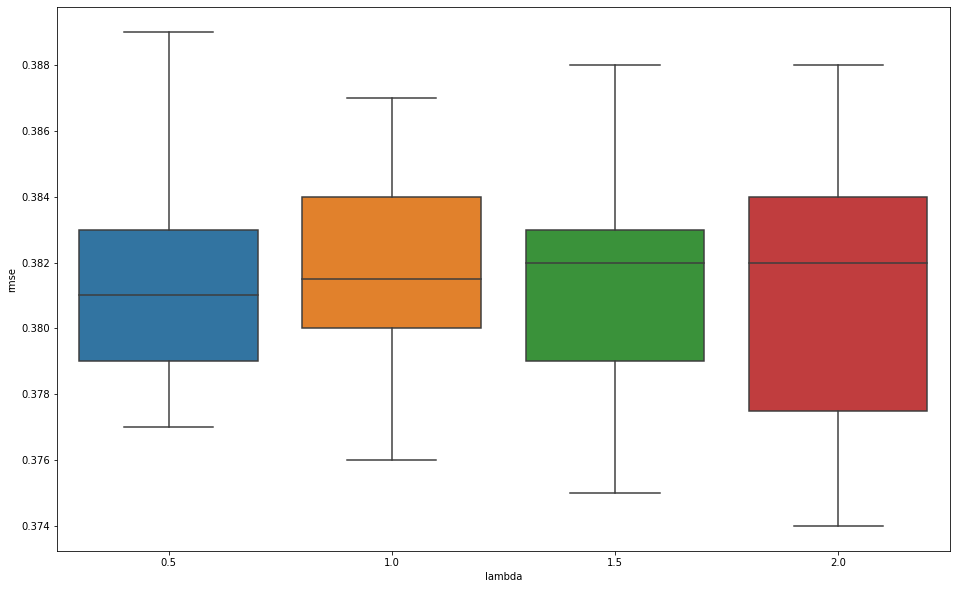

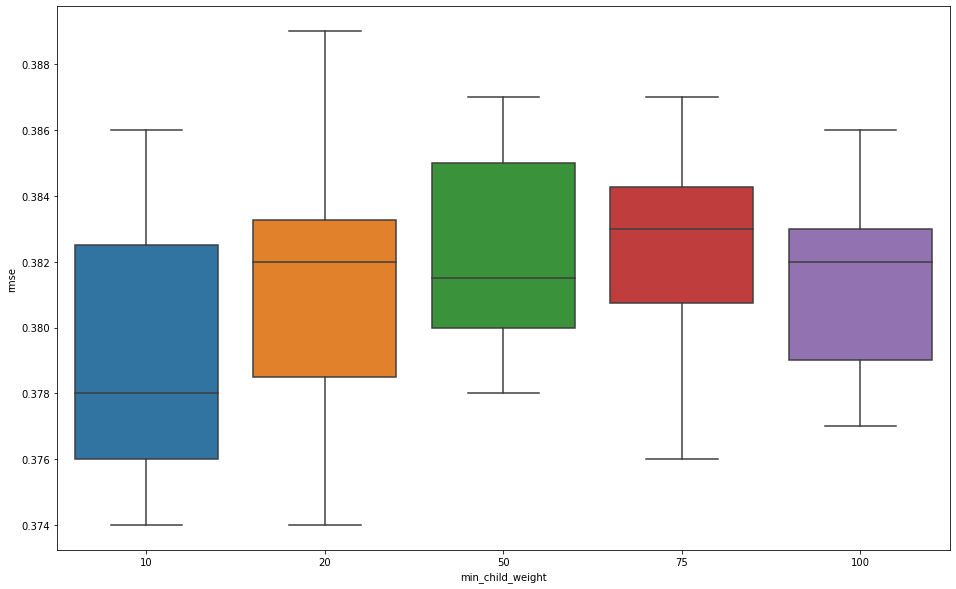

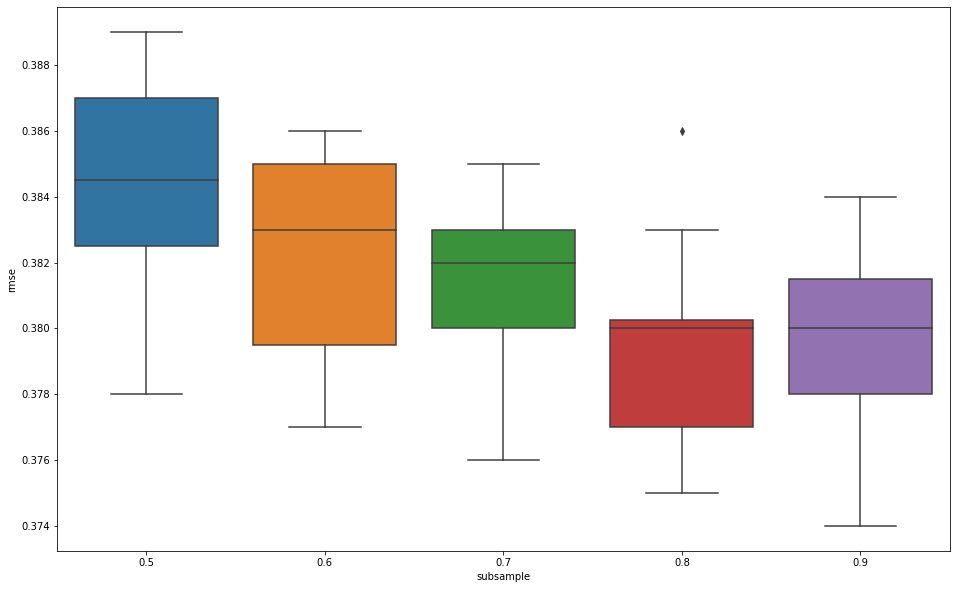

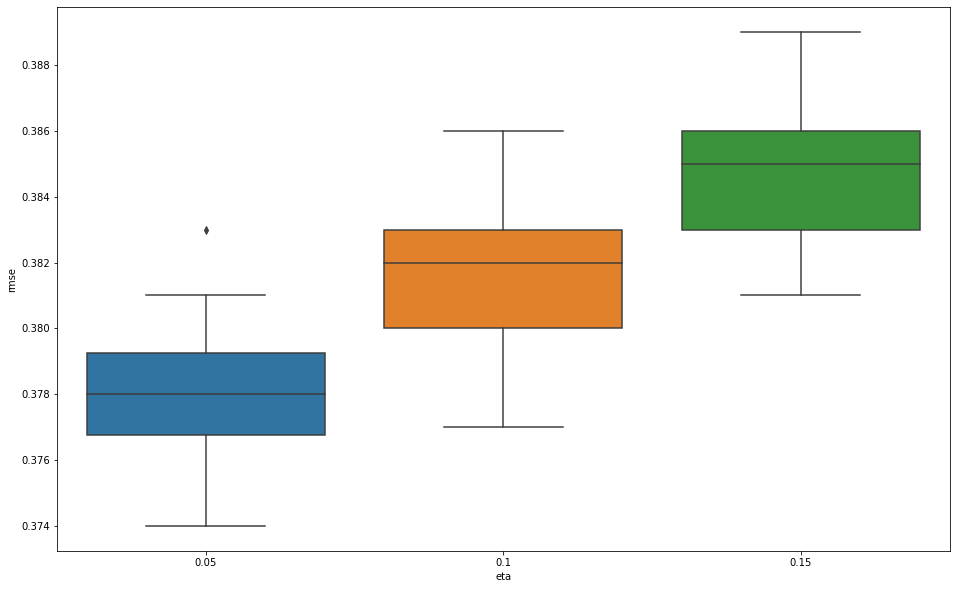

In [160]:
for i, par in enumerate(['lambda', 'min_child_weight', 'subsample', 'eta']):
    fig, ax = plt.subplots()
    ax = sns.boxplot(x=par, y='rmse', data=paropt)

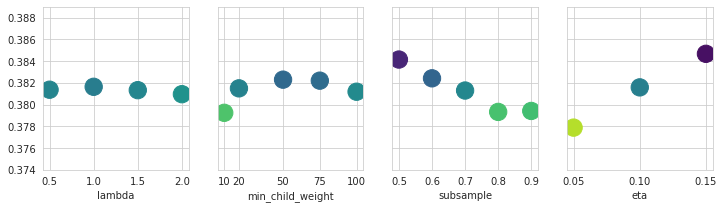

In [162]:
with sns.axes_style('whitegrid'):
    fig, axs = plt.subplots(ncols=4, sharey=True, figsize=(12, 3))
    for i, par in enumerate(['lambda', 'min_child_weight', 'subsample', 'eta']):
        mean_rmse = paropt.groupby(par).mean()[['rmse']].reset_index()
        axs[i].scatter(mean_rmse[par].values, mean_rmse['rmse'].values, c=mean_rmse['rmse'].values, s=300, cmap='viridis_r', vmin=.377, vmax=.385)
        axs[i].set_xlabel(par)
        axs[i].set_xticks(mean_rmse[par].values)
        axs[i].set_ylim(paropt.rmse.min(), paropt.rmse.max())

eta를 낮추면 성능이 크게 향상될 수 있습니다. subsample이 높고 child가 낮을수록 결과가 향상됩니다. 람다는 그다지 중요하지 않습니다.